In [1]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

import numpyro
numpyro.set_host_device_count(4)

import numpy as np
from scipy.stats import norm
from scipy.integrate import simpson as simpson_scipy
from scipy.integrate import cumulative_simpson as cum_simpson_scipy

from tqdm import trange

from jax import numpy as jnp
from jax import random
from jax.scipy.stats.norm import logcdf as jax_norm_logcdf
from jax.scipy.stats.norm import cdf as jax_norm_cdf
from jax.scipy.special import logsumexp
from numpyro import plate, sample, factor
from numpyro.distributions import Normal, Uniform, TruncatedNormal
from numpyro.infer import MCMC, NUTS, init_to_median
from quadax import simpson


import candel
from candel import SPEED_OF_LIGHT
from candel.model import LOSInterpolator

import matplotlib.pyplot as plt
%matplotlib inline


def r2mu(r):
    return 5 * jnp.log10(r) + 25

def mu2r(mu):
    return 10**((mu - 25) / 5)

def r2czcosmo(r, H0=70):
    return r * H0

Retained 38 out of 1500 points.


/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_78545/2099966814.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


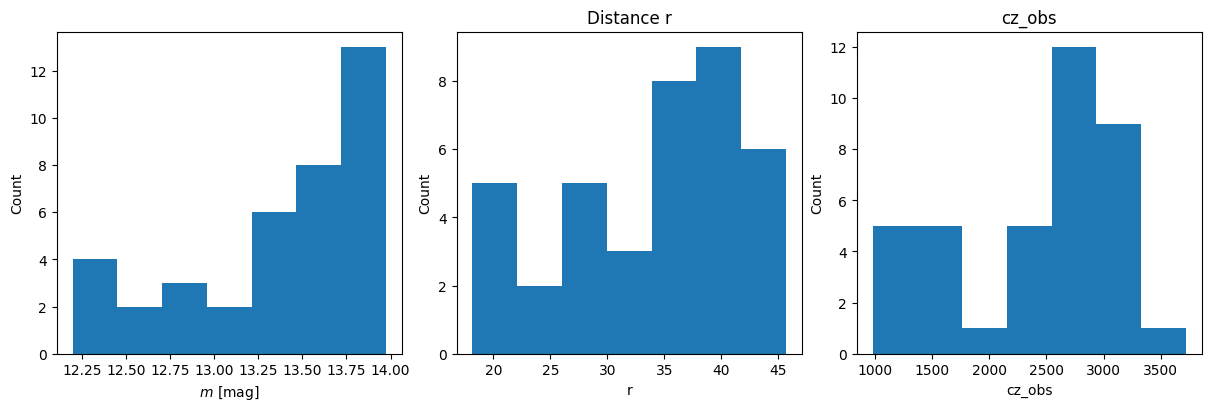

In [6]:
npoints = 1500

Rmax = 150
M = -19.25
sigma_v = 250
e_mag = 0.1
H0 = 70
mag_lim = 14.0
cz_lim = None

r_grid = np.linspace(1e-4, Rmax, 300)


def generate_mock(seed, mag_lim=None, cz_lim=None, verbose=False,
                  make_plot=False, mag_lim_width=0.5, ):
    gen = np.random.default_rng(seed)
    r = Rmax * gen.uniform(0, 1, npoints)**(1/3)

    mag = gen.normal(r2mu(r) + M, e_mag, )
    cz = gen.normal(r2czcosmo(r, H0), sigma_v)

    mask = np.ones_like(mag, dtype=bool)
    if mag_lim is not None:
        # p_sel = 1 - norm(loc=mag_lim, scale=mag_lim_width).cdf(mag)
        # mask &= p_sel > gen.random(npoints)
        mask &= mag < mag_lim
    if cz_lim is not None:
        mask &= cz < cz_lim

    if verbose:
        print(f"Retained {np.sum(mask)} out of {npoints} points.")

    mag, cz, r = mag[mask], cz[mask], r[mask]

    if make_plot:
        fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
        axes[0].hist(mag, bins="auto")
        axes[0].set_xlabel(r"$m ~ [\mathrm{mag}]$")
        axes[0].set_ylabel('Count')

        axes[1].hist(r, bins="auto")
        axes[1].set_title(r'Distance r')
        axes[1].set_xlabel('r')
        axes[1].set_ylabel('Count')

        axes[2].hist(cz, bins="auto")
        axes[2].set_title('cz_obs')
        axes[2].set_xlabel('cz_obs')
        axes[2].set_ylabel('Count')

        fig.show()

    return mag, cz, r
  

__ = generate_mock(2, mag_lim, cz_lim, verbose=True, make_plot=True)

In [15]:
class FluxSelectionModel:

    def __init__(self, mag_lim, e_mag, Rmax_survey, sigma_v, H0, **kwargs):
        self.mag_lim = mag_lim
        self.e_mag = e_mag
        self.Rmax_survey = Rmax_survey
        self.sigma_v = sigma_v
        self.H0 = H0

    def __call__(self, mag_obs, cz_obs):
        N = len(mag_obs)

        M = sample('M', Normal(-19.25, 1.0))
        factor("global_norm", N * 0.6 * jnp.log(10) * M)

        with plate('galaxies_lp', N):
            r = sample('r', Uniform(0, self.Rmax_survey))
            factor("log_r", 2 * jnp.log(r) - 3 * jnp.log(self.Rmax_survey) + jnp.log(3))


        with plate('galaxies_ll', N):
            sample('mag_obs', Normal(5 * jnp.log10(r) + 25 + M, self.e_mag), obs=mag_obs)
            sample('cz_obs', Normal(r2czcosmo(r, H0=H0), sigma_v), obs=cz_obs)



class EmpiricalModel:

    def __init__(self, e_mag, Rmax_survey, sigma_v, H0, **kwargs):
        self.e_mag = e_mag
        self.Rmax_survey = Rmax_survey
        self.sigma_v = sigma_v
        self.H0 = H0

    def __call__(self, mag_obs, cz_obs):
        N = len(mag_obs)

        R = sample('R', Uniform(0, 300))
        p = sample('p', TruncatedNormal(2.0, 0.1, low=0.1))
        n = sample('n', TruncatedNormal(1.0, 10.0, low=0))

        M = sample('M', Normal(-19.25, 1.0))
        # factor("global_norm", N * 0.6 * jnp.log(10) * M)

        with plate('galaxies_lp', N):
            r = sample('r', Uniform(0, self.Rmax_survey))

            factor("log_r", candel.model.log_prior_r_empirical(
                r, R, p, n, self.Rmax_survey))

        with plate('galaxies_ll', N):
            sample('mag_obs', Normal(5 * jnp.log10(r) + 25 + M, self.e_mag), obs=mag_obs)
            sample('cz_obs', Normal(r2czcosmo(r, H0=H0), sigma_v), obs=cz_obs)



In [32]:
num_warmup = 500
num_steps = 1500


# model_gen = FluxSelectionModel
model_gen = EmpiricalModel
param_bias_test = "M"

nrepeat = 100
progress_bar = nrepeat == 1

bias = []

for i in trange(nrepeat, desc="Running MCMC", disable=progress_bar):
    mag, cz, r = generate_mock(500 + i, mag_lim=mag_lim, cz_lim=cz_lim)

    model = model_gen(mag_lim=mag_lim, cz_lim=cz_lim, e_mag=e_mag, Rmax_survey=Rmax,
                  sigma_v=sigma_v, M=M, H0=H0)

    kernel = NUTS(model, init_strategy=init_to_median(num_samples=2500))
    mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_steps, num_chains=4, progress_bar=progress_bar)
    mcmc.run(
        random.PRNGKey(i),
        mag_obs=jnp.asarray(mag),
        cz_obs=jnp.asarray(cz),
        )

    samples = mcmc.get_samples()
    if progress_bar:
        mcmc.print_summary()
    
    param = param_bias_test
    if param == "M":
        x0 = M
    elif param == "H0":
        x0 = H0
    else:
        raise ValueError("Unknown parameter: {}".format(param))

    bias.append((jnp.mean(samples[param]) - x0) / jnp.std(samples[param]))

bias = jnp.asarray(bias)

Running MCMC: 100%|██████████| 100/100 [03:11<00:00,  1.92s/it]


In [33]:
# np.save("bias_flux_sel.npy", bias)

np.save('bias_empirical.npy', bias)

### Parameter bias test

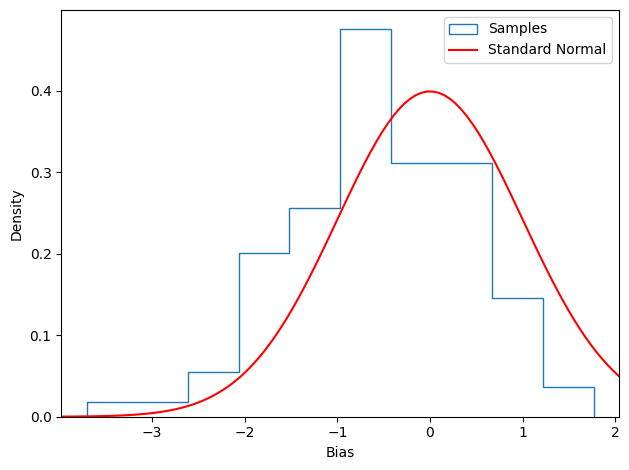

In [34]:
plt.figure()

plt.hist(bias, bins="auto", density=True, label="Samples", histtype="step")

xlim = plt.xlim()
xrange = np.linspace(*xlim, 100)
plt.plot(xrange, norm.pdf(xrange), label="Standard Normal", color='red')
plt.xlim(*xlim)

plt.xlabel("Bias")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.savefig("/Users/rstiskalek/Downloads/mock_test_H0.png", dpi=450)
plt.show()

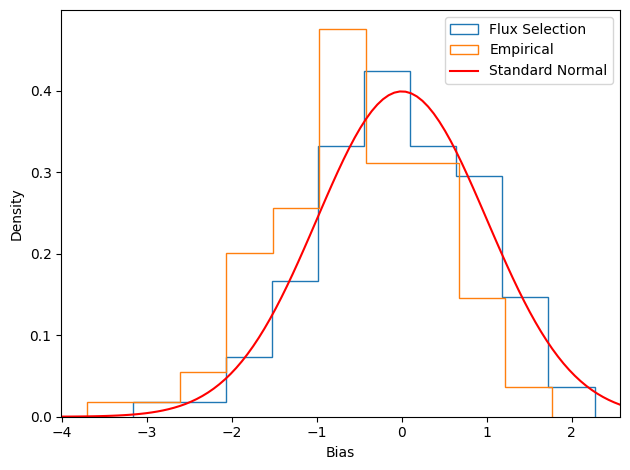

In [6]:
bias_flux = np.load("bias_flux_sel.npy")
bias_empirical = np.load("bias_empirical.npy")

plt.figure()

plt.hist(bias_flux, bins="auto", density=True, label="Flux Selection", histtype="step")
plt.hist(bias_empirical, bins="auto", density=True, label="Empirical", histtype="step")

xlim = plt.xlim()
xrange = np.linspace(*xlim, 100)
plt.plot(xrange, norm.pdf(xrange), label="Standard Normal", color='red')
plt.xlim(*xlim)

plt.xlabel("Bias")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.savefig("/Users/rstiskalek/Downloads/mock_test_H0.png", dpi=450)
plt.show()

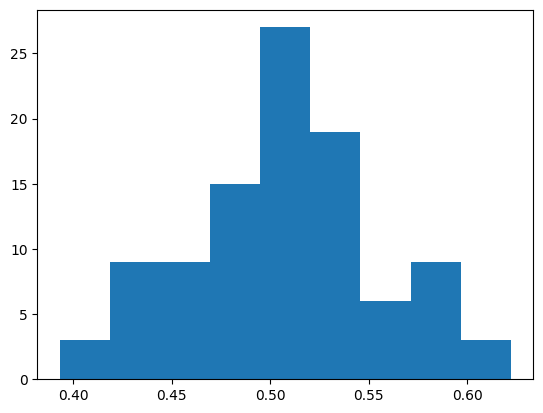

In [3]:
plt.figure()
plt.hist(bias_flux - bias_empirical, bins="auto")
plt.show()

### Recover back the total number of objects

In [85]:
from jax.scipy.stats.norm import logcdf as norm_logcdf
from quadax import simpson
from scipy.special import comb
from scipy.stats import norm

from jax.scipy.special import gammaln

def log_binom(N, n):
    N = jnp.asarray(N, )
    n = jnp.asarray(n, )
    valid = (n >= 0) & (n <= N) & jnp.isfinite(N) & jnp.isfinite(n)
    val = gammaln(N + 1.0) - gammaln(n + 1.0) - gammaln(N - n + 1.0)
    return jnp.where(valid, val, -jnp.inf)


def log_p_det(M, Rmax, mag_lim, e_mag):
    norm = jnp.log(3) + jnp.log(jnp.log(10)) - 3 * jnp.log(Rmax) - jnp.log(5) - 3 * M / 5 * jnp.log(10)

    grid_center = mag_lim - 25
    grid_left = grid_center - 10
    grid_right = grid_center + 20* e_mag

    x = jnp.linspace(grid_left, grid_right, 1000)
    log_y = 3 * x / 5 * jnp.log(10) + norm_logcdf((mag_lim - 25 - x) / e_mag)
    log_intg = jnp.log(simpson(jnp.exp(log_y), x=x))

    # plt.figure()
    # plt.plot(x, jnp.exp(log_y), label="logcdf")
    # plt.show()

    return norm + log_intg


def p_det_scipy(M, Rmax, mag_lim, e_mag):
    r = np.linspace(1e-5, Rmax, 1000)
    mu = r2mu(r)
    y = 3 * r**2 * norm().cdf((mag_lim - (M + mu)) / e_mag) / Rmax**3
    return simpson(y, x=r)


In [ ]:
N = np.arange(8000, 12_000)
n = 890

y = np.full(len(N), np.nan)
y2 = np.full(len(N), np.nan)
for i, Ni in enumerate(N):
    log_pS = jnp.log(p_det_scipy(M, Rmax, mag_lim, e_mag))
    log_pS_comp = jnp.log(-jnp.expm1(log_pS))
    y[i] = log_binom(Ni - 1, n - 1) + n * log_pS + (Ni - n) * log_pS_comp


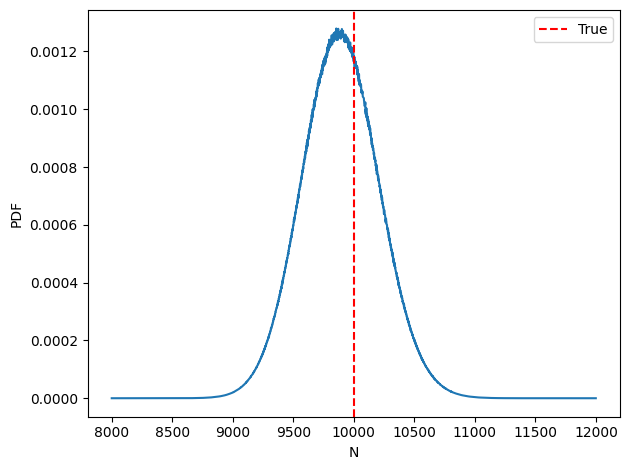

In [122]:
plt.figure()
plt.plot(N, jnp.exp(y))

plt.axvline(10_000, c="red", linestyle="--", label="True")

plt.xlabel("N")
plt.ylabel("PDF")
plt.legend()
plt.tight_layout()

plt.savefig("/Users/rstiskalek/Downloads/Ntest.png", dpi=450)

plt.show()

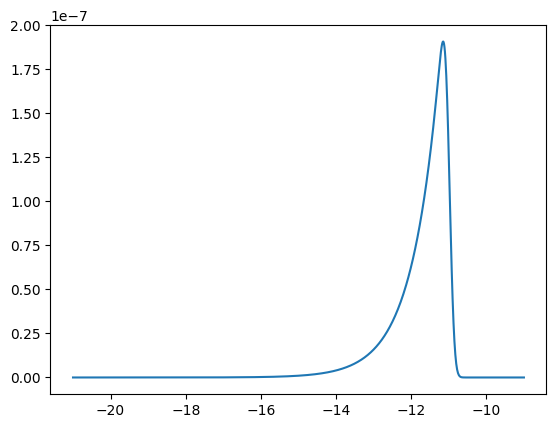

In [152]:
ps = log_p_det(M, Rmax, mag_lim, e_mag)

In [149]:
npoints * 0.66651535

6665.153499999999

In [66]:
grid_center = mag_lim - 25
grid_left = grid_center - 5
grid_right = grid_center + 20 * e_mag

x = jnp.linspace(grid_left, grid_right, 1000)

y = 3 * x / 5 * jnp.log(10) + norm_logcdf((mag_lim - 25 - x) / e_mag)
# y = norm_logcdf(x)

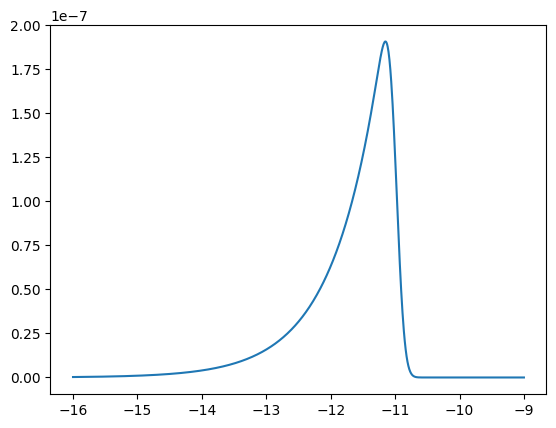

In [68]:
plt.figure()
plt.plot(x, jnp.exp(y), label="logcdf")

plt.show()